<b>Problem Definition:</b> 
In this assignment, it is asked from us to implement an age estimator KNN (and weighted KNN), using given FGNET dataset. <br>
Eventually, I should have two models (one KNN and one WeightedKNN) that estimates people's ages using their photographs.
<br>

<div class="alert alert-block alert-info">
Follow the code to see the details of the implementation. You may find comments in the code about variables and functions declared, and explanations (if necessary) of code snippets below the respective code snippet.
</div>

All of the imports are here and they are used in respective places.

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
from math import exp
import time
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import glob

In [2]:
df = pd.read_csv("data.csv")
df

,Name,Age
0,055A12.JPG,12.0
1,016A03.JPG,3.0
2,054A06.JPG,6.0
3,053A06.JPG,6.0
4,080A02.JPG,2.0
...,...,...
895,060A10.JPG,10.0
896,082A18.JPG,18.0
897,082A23.JPG,23.0
898,074A12.JPG,12.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    900 non-null    object 
 1   Age     900 non-null    float64
dtypes: float64(1), object(1)
memory usage: 14.2+ KB


I've read the given csv file and check if there's a problem with the data. Age attribute was in type of "float64" which was the important thing.

In [4]:
images = []

for name in df["Name"]:
    image = cv2.imread(os.path.join("images", name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (30,30))
    image = image / 255
    image = image.flatten()
    images.append(image)
    
print(len(images))

900


I've imported the dataset using the given "data.csv" file. For each image, I both read the image and preprocessed it.
Preprocessing steps:
- Turn image into greyscale.
- Resize images into 30x30
- Normalize the images by dividing the image array by 255
- Flattening the image so that I can use the image array in my model

After preprocess the image, I added it into <b>images</b> list.


Here, greyscaling images was necessary in two ways:
1. I needed an flat array to feed into the model, but and RGB image is an array of arrays while a greyscale image is just a 2D array.
2. Some images are RGB and some images are greyscale in the dataset meaning that the dataset is a bit mixed in that manner. I had to fix this.

I was considiring making the images bigger than 30x30 but even with that tiny images, the algorithm took a lot of time to run (see the results below) and it would be inconvenient to resize it anything bigger than 30x30. Maybe with bigger images I might get a better score but when I considered the runtime and correctness, this seemed like a good balance.

In [5]:
df["Image"] = images

In [6]:
df

,Name,Age,Image
0,055A12.JPG,12.0,"[0.7490196078431373, 0.7686274509803922, 0.768..."
1,016A03.JPG,3.0,"[0.7450980392156863, 0.596078431372549, 0.7607..."
2,054A06.JPG,6.0,"[0.054901960784313725, 0.050980392156862744, 0..."
3,053A06.JPG,6.0,"[0.5647058823529412, 0.5803921568627451, 0.325..."
4,080A02.JPG,2.0,"[0.43529411764705883, 0.43529411764705883, 0.4..."
...,...,...,...
895,060A10.JPG,10.0,"[0.4823529411764706, 0.47058823529411764, 0.47..."
896,082A18.JPG,18.0,"[0.4745098039215686, 0.47843137254901963, 0.54..."
897,082A23.JPG,23.0,"[0.1843137254901961, 0.17647058823529413, 0.17..."
898,074A12.JPG,12.0,"[0.19215686274509805, 0.19607843137254902, 0.1..."


In [7]:
X = df["Image"]

In [8]:
y = df["Age"]

I added the <b>images</b> to the DataFrame I had. <br>
This was done just because it seems like a logical thing at that time. Now I see that it is not necessary.<br>
But I think my model needs the feature data (<b>X</b>) in pd.Series format, and I work a bit hard to make the model work.<br>
So I will just leave it that way even though other ways to turn an array into pd.Series comes into my mind right now.

In [9]:
class KNNRegressor:
    
    #Constructor with one parameter: n_neighbours.
    #n_neighbours is the "k" value in KNN.
    def __init__(self,  n_neighbours):
        self.n_neighbours = n_neighbours
        
    #Functions "get_params" and "set_params" are here just because
    #I used KFoldCrossValidation from sklearn library.
    #Sklearn requires the estimator that will be passed to sklearn.model_selection.cross_val_score function
    #to be a "sklearn estimator" and these two functions makes this regressor a "sklearn estimator".
    #These functions are from sklearn documentation which means they provided these two functions.
    def get_params(self, deep=True):
        return {"n_neighbours": self.n_neighbours}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    
    #As there is no learning in KNN, all the train (or fit) function does is to remember the given data and target values.
    def fit(self, src, target): 
        self.X = src
        self.y = target
    
    
    #I couldn't just handle an array of images at once, so my here is the solution!:
    #I declared "predict_one_image" function and this function predicts just one image.
    #Then in "predict" method, I loop over the given image array, and call this function to predict images.
    
    #This function first find the distances between target image t and each image from the dataset (X), then
    #inserts this distance to "distances" pd.Series. There were problem with indexes so
    #I had to use pd.Series instead of regular arrays.
    #Key thing here is that, while inserting a distance to "distances", you insert the distance to a specific index,
    #to be more precise, this specific index is the index of the image in dataset (X).
    #An example to make it more clear:
    #We have target image t and 10 images from dataset which are indexed from 0 to 9.
    #When we insert the distance between image_0 and image_t,
    #,we insert it to index 0 (index of the image_0 in dataset) in "distances".
    #So that when we need to look for min(distances)'s "y" value, we can use this index.
    
    #This function uses L1 distance, meaning that I just substracted two images and get the absolutes. Then I add the absolutes
    #to get the distance.
    def predict_one_image(self, image):
        distances = pd.Series(dtype="float64")
        prediction = 0
        
        for index in self.X.index:
            dummy_series = pd.Series(data = np.sum(abs(image-X[index])), index=[index])
            distances = distances.append(dummy_series)
        
        for n in range(self.n_neighbours):
            min_row = distances[distances == min(distances)]
            min_ = self.y[min_row.index[0]]
            prediction += min_
            
        prediction /= self.n_neighbours
        
        return prediction
    
    def predict(self, x_pred):
        y_pred = []
        
        for item in x_pred:
            y_pred.append(self.predict_one_image(item))
            
        return y_pred

In [10]:
class WeightedKNNRegressor:
    
    def __init__(self,  n_neighbours):
        self.n_neighbours = n_neighbours
        
    def get_params(self, deep=True):
        return {"n_neighbours": self.n_neighbours}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    def fit(self, src, target): 
        self.X = src
        self.y = target
    
    #Similarity between two image is the exponential of the absolute distance between them.
    def kernel(self, distance):
        return exp(abs(distance))
    
    #This function does everything in it does in KNN, but with weights. Now the prediction is:
    #for n_neighbours a = y value of the min(distances)*weight,
    #then a / total_weight
    def predict_one_image(self, image):
        distances = pd.Series(dtype="float64")
        prediction = 0
        total_weight = 0
        
        for index in self.X.index:
            dummy_series = pd.Series(data = np.sum(abs(image-X[index])), index=[index])
            distances = distances.append(dummy_series)
        
        for n in range(self.n_neighbours):
            min_row = distances[distances == min(distances)]
            min_ = self.y[min_row.index[0]]
            weight = self.kernel(min_row.values[0])
            prediction += min_ * weight
            total_weight += weight
            
        prediction /= total_weight
        
        return prediction
    
    def predict(self, x_pred):
        y_pred = []
        
        for item in x_pred:
            y_pred.append(self.predict_one_image(item))
            
        return y_pred

I declared KNN and WeightedKNN as classes because a function obviously was not enough for it. All other explanations needed are in the code comments.

In [11]:
neighbours = [1, 3, 5, 7]
cvs= [3, 4, 5, 10]


def mean(list_):
    return sum(list_) / len(list_)

scores = []

start_time = time.process_time()

for n in neighbours:
    for cv in cvs:
        
        print("-For", n, "neighbours,", cv, "fold cross validation using kNN-")
        start_time_1 = time.process_time()
        scores_1 = cross_val_score(KNNRegressor(n), X, y, cv=cv, scoring="neg_mean_absolute_error")
        total_time_1 = time.process_time() - start_time_1
        
        print(scores_1)
        print("Mean MAE:")
        print(mean(scores_1))
        scores.append(["knn", n, cv, scores_1, mean(scores_1), total_time_1])
        
        print("This process took in total of", total_time_1, "seconds.")
        print()
        
        
        print("-For", n, "neighbours and", cv, "fold cross validation using WeightedkNN-")
        start_time_2 = time.process_time()
        scores_2 = cross_val_score(WeightedKNNRegressor(n), X, y, cv=cv, scoring="neg_mean_absolute_error")
        total_time_2 = time.process_time() - start_time_2
        
        print(scores_2)
        print("Mean MAE:")
        print(mean(scores_2))
        scores.append(["wknn", n, cv, scores_2, mean(scores_2), total_time_2])
        
        print("This process took in total of", total_time_2, "seconds.")
        print()
        print()
        
print("The whole process took", time.process_time() - start_time, "seconds.")

-For 1 neighbours, 3 fold cross validation using kNN-
[-10.39       -11.53666667 -10.98333333]
Mean MAE:
-10.97
This process took in total of 120.6875 seconds.

-For 1 neighbours and 3 fold cross validation using WeightedkNN-
[-10.39       -11.53666667 -10.98333333]
Mean MAE:
-10.97
This process took in total of 121.234375 seconds.


-For 1 neighbours, 4 fold cross validation using kNN-
[-10.11555556 -11.73777778 -10.07555556 -11.28888889]
Mean MAE:
-10.804444444444444
This process took in total of 135.4375 seconds.

-For 1 neighbours and 4 fold cross validation using WeightedkNN-
[-10.11555556 -11.73777778 -10.07555556 -11.28888889]
Mean MAE:
-10.804444444444444
This process took in total of 138.375 seconds.


-For 1 neighbours, 5 fold cross validation using kNN-
[ -9.58888889 -11.08333333 -12.21666667 -10.35555556 -11.13333333]
Mean MAE:
-10.875555555555556
This process took in total of 150.796875 seconds.

-For 1 neighbours and 5 fold cross validation using WeightedkNN-
[ -9.5888888

In [12]:
scores_df = pd.DataFrame(data = scores, columns = ["Model", "k for KNN", "k for CV", "MAE Scores", "MAE Mean", "Runtime"])

In [13]:
scores_df

,Model,k for KNN,k for CV,MAE Scores,MAE Mean,Runtime
0,knn,1,3,"[-10.39, -11.536666666666667, -10.983333333333...",-10.970000,120.687500
1,wknn,1,3,"[-10.39, -11.536666666666667, -10.983333333333...",-10.970000,121.234375
2,knn,1,4,"[-10.115555555555556, -11.737777777777778, -10...",-10.804444,135.437500
3,wknn,1,4,"[-10.115555555555556, -11.737777777777778, -10...",-10.804444,138.375000
4,knn,1,5,"[-9.588888888888889, -11.083333333333334, -12....",-10.875556,150.796875
5,wknn,1,5,"[-9.588888888888889, -11.083333333333334, -12....",-10.875556,150.000000
6,knn,1,10,"[-8.644444444444444, -10.922222222222222, -9.8...",-10.740000,167.046875
7,wknn,1,10,"[-8.644444444444444, -10.922222222222222, -9.8...",-10.740000,173.421875
8,knn,3,3,"[-10.39, -11.536666666666667, -10.983333333333...",-10.970000,124.625000
9,wknn,3,3,"[-10.39, -11.536666666666667, -10.983333333333...",-10.970000,125.578125


In [14]:
scores_df.drop(["MAE Scores"], axis=1, inplace=True)

In [15]:
scores_df

,Model,k for KNN,k for CV,MAE Mean,Runtime
0,knn,1,3,-10.970000,120.687500
1,wknn,1,3,-10.970000,121.234375
2,knn,1,4,-10.804444,135.437500
3,wknn,1,4,-10.804444,138.375000
4,knn,1,5,-10.875556,150.796875
5,wknn,1,5,-10.875556,150.000000
6,knn,1,10,-10.740000,167.046875
7,wknn,1,10,-10.740000,173.421875
8,knn,3,3,-10.970000,124.625000
9,wknn,3,3,-10.970000,125.578125


So, this is the final, large DataFrame that consist everything we want to see! <br>

An important notice: When we increase the k for CV, that means we increase the amount of training data and we decrease the amount of test data.

Here we can see from DataFrame is that:
- Mean MAE does not really change even though we change both k for KNN and k for CV.
- Runtime goes way too much up when k for CV goes up.
- Weighted KNN and KNN gives the literally exact result (interestingly) with same parameters (k for KNN and CV).

In [16]:
scores_df[scores_df["MAE Mean"] == min(scores_df["MAE Mean"])]

,Model,k for KNN,k for CV,MAE Mean,Runtime
0,knn,1,3,-10.97,120.687500
1,wknn,1,3,-10.97,121.234375
8,knn,3,3,-10.97,124.625000
9,wknn,3,3,-10.97,125.578125
16,knn,5,3,-10.97,133.968750
17,wknn,5,3,-10.97,126.281250
24,knn,7,3,-10.97,134.093750
25,wknn,7,3,-10.97,123.593750


So these are the models with lowest MAE Means. It is obvious that the MAE Mean changed with the selection of k for CV but not with the k for KNN. I doubt if this should be the case but the results are there and they are true (I guess)! I will go with the one with lowest runtime either so my model will be the WeightedKNN with k for KNN = 5, k for CV = 3.

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

classifier = WeightedKNNRegressor(5)

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

In [18]:
for index, item in enumerate(y_test):
    print("Image", index, ":")
    print("Estimated age:", y_pred[index])
    print("True age:", item)
    print("------------------")

Image 0 :
Estimated age: 2.0
True age: 12.0
------------------
Image 1 :
Estimated age: 1.0
True age: 6.0
------------------
Image 2 :
Estimated age: 6.999999999999999
True age: 5.0
------------------
Image 3 :
Estimated age: 22.999999999999996
True age: 13.0
------------------
Image 4 :
Estimated age: 3.0
True age: 10.0
------------------
Image 5 :
Estimated age: 2.9999999999999996
True age: 16.0
------------------
Image 6 :
Estimated age: 46.0
True age: 39.0
------------------
Image 7 :
Estimated age: 2.0
True age: 20.0
------------------
Image 8 :
Estimated age: 5.000000000000001
True age: 3.0
------------------
Image 9 :
Estimated age: 12.999999999999998
True age: 16.0
------------------
Image 10 :
Estimated age: 23.0
True age: 27.0
------------------
Image 11 :
Estimated age: 12.0
True age: 25.0
------------------
Image 12 :
Estimated age: 26.000000000000004
True age: 15.0
------------------
Image 13 :
Estimated age: 36.0
True age: 16.0
------------------
Image 14 :
Estimated age:

Since this is an regression problem, it is not that logical to expect the exact same numbers in estimation and truth. But they should be close. However, what I see here is that when the estimator estimates a truth 30 as 35, it is good estimation for this model even though 5 is a large number for this problem. <br>

So let's see some misestimated images: <br>
Image 23 estimated as 0 while true age is 21 and Image 24 estimated as 28 while true age is 4.

Let's check these images:

In [19]:
X_test.head(25)

70     [0.5764705882352941, 0.5764705882352941, 0.580...
827    [0.24705882352941178, 0.13333333333333333, 0.1...
231    [0.07058823529411765, 0.058823529411764705, 0....
588    [0.34509803921568627, 0.33725490196078434, 0.3...
39     [0.21176470588235294, 0.24705882352941178, 0.2...
731    [0.5019607843137255, 0.4980392156862745, 0.498...
299    [0.6941176470588235, 0.6941176470588235, 0.690...
110    [0.6588235294117647, 0.6745098039215687, 0.647...
72     [0.5254901960784314, 0.5372549019607843, 0.470...
86     [0.45098039215686275, 0.45098039215686275, 0.4...
139    [0.4823529411764706, 0.3333333333333333, 0.266...
533    [0.7725490196078432, 0.7725490196078432, 0.764...
801    [0.29411764705882354, 0.2823529411764706, 0.31...
120    [0.4470588235294118, 0.45098039215686275, 0.46...
711    [0.792156862745098, 0.7568627450980392, 0.7372...
590    [0.6705882352941176, 0.6666666666666666, 0.662...
168    [0.14901960784313725, 0.12941176470588237, 0.1...
422    [0.5411764705882353, 0.5

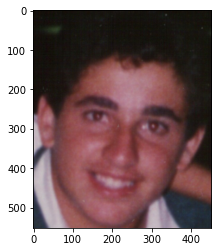

In [20]:
image_23 = df["Name"][333]
img_23 = cv2.imread("images\\"+image_23)
rgb_img = cv2.cvtColor(img_23, cv2.COLOR_BGR2RGB)

plt.imshow(rgb_img)
plt.show()

It is a bit interesting that the estimation is 0, instead of something non zero. This is because my implementation, since if there will be no estimation, then prediction is 0 by default but I doubt if there is any problem with the implementation. To see that, here is the number of 0 predictions:

In [21]:
y_pred.count(0)

11

I don't know what caused this but it is surely interesting. Maybe the kernel function is 0 in these 11 instances.

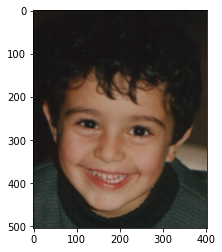

In [22]:
image_24 = df["Name"][542]
img_24 = cv2.imread("images\\"+image_24)
rgb_img = cv2.cvtColor(img_24, cv2.COLOR_BGR2RGB)

plt.imshow(rgb_img)
plt.show()

I think this image is predicted false because the facial features of this boy is actually similar to elder people. An example could be image_23 up there. It looks like what makes a person look young is kind of hard to understand.